In [14]:
import scipy
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import glob
import imageio

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2715211190013757046
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3586654208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4978975218573691889
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [16]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
def load_data(pathA, pathB, row_shape, col_shape, batch_size=32):
    """pathA(str): path that contains image set A
        pathB(str): path that contains image set B"""
    # list of file names
    path_imgA=glob.glob(pathA)
    path_imgB=glob.glob(pathB)
    
    n_images = min(len(path_imgA), len(path_imgB))
    n_batch = int(n_images//batch_size)
    # list of chosen filenames
    chosen_imgA = np.random.choice(path_imgA, n_images, replace=False)
    chosen_imgB = np.random.choice(path_imgB, n_images, replace=False)
    
    for i in range(n_batch-1):
        imgsA=[]

        imgA=chosen_imgA[i*batch_size : (i+1)*batch_size]
        for j in imgA:
            img=imageio.imread(j)
            img=scipy.misc.imresize(img, size=(row_shape, col_shape,3))
            imgsA.append(img)
        
        imgsB=[]
        imgB=chosen_imgB[i*batch_size : (i+1)*batch_size]
        for j in imgB:
            img=imageio.imread(j)
            img=scipy.misc.imresize(img, size=(row_shape, col_shape,3))
            imgsB.append(img)
        
        imgsA=np.array(imgsA)/127.5-1
        imgsB=np.array(imgsB)/127.5-1
        
        yield imgsA,imgsB
        
        


In [5]:
class CycleGan():
    def __init__(self, path, img_rows, img_cols, img_channels, cycle_lambda):
        
        # image parameters
        self.path=path
        self.img_rows=img_rows
        self.img_cols=img_cols
        self.channels=img_channels
        self.img_shape=(self.img_rows, self.img_cols, self.channels)
        
        
        
        # build discriminator and generator
        self.optimizer=Adam(0.0002, 0.5)
        self.Dx=self.build_discriminator()
        self.Dx.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        self.Dy=self.build_discriminator()
        self.Dy.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        self.genXY=self.build_generator()
        self.genYX=self.build_generator()
        
        # weights
        self.cycle_lambda = cycle_lambda
        self.id_lambda = 0.1 * self.cycle_lambda
        
        self.build_gan()
        
    def train(self, epochs=10, batch_size=32):
        
        real = 0.9 * np.ones((batch_size,)+(self.img_rows//16,self.img_cols//16,1))
        fake = np.zeros((batch_size,)+(self.img_rows//16,self.img_cols//16,1))
        for epoch in range(epochs):
            if epoch%3==0:
                print(epoch)
            for imgX,imgY in load_data(self.path+"\\trainA\\*.jpg", self.path+"\\trainB\\*.jpg", self.img_rows, self.img_cols,batch_size=batch_size):
                # train discriminator
                fakeY = self.genXY.predict(imgX)
                fakeX = self.genYX.predict(imgY)
                
                # real images
                self.Dy.train_on_batch(imgY, real)
                self.Dx.train_on_batch(imgX, real)
                # fake images
                self.Dy.train_on_batch(fakeY, fake)
                self.Dx.train_on_batch(fakeX, fake)
            
                '''train generator'''
                self.gan.train_on_batch([imgX, imgY],
                                  [real, real,
                                      imgX, imgY,
                                          imgX, imgY])

        return self.gan, self.genXY, self.genYX
    
    
    def encode(self, input_layer, filters):
        layer = Conv2D(filters, kernel_size=5, strides=2, padding='same')(input_layer)
        layer = LeakyReLU(alpha=0.2)(layer)
        layer = InstanceNormalization()(layer)
        return layer
    
    def decode(self, input_layer, forward_layer, filters):
        layer = UpSampling2D(size=2)(input_layer)
        layer = Conv2D(filters, kernel_size=5, strides=1, padding='same', activation='relu')(layer)
        layer = InstanceNormalization()(layer)
        layer = Concatenate()([layer, forward_layer])
        return layer
    
    def build_gan(self):
        
        '''cycle'''
        # image parameter
        imageX=Input(shape=self.img_shape)
        imageY=Input(shape=self.img_shape)
        # generated images
        fakeX=self.genYX(imageY)
        fakeY=self.genXY(imageX)
        # cyclded images images
        cycleX =self.genYX(fakeY)
        cycleY =self.genXY(fakeX)
        
        '''identity map'''
        # identity map: used to preserve the color, prevent color reverse
        id_imageX=self.genYX(imageX)
        id_imageY=self.genXY(imageY)
        
        # do not train discriminator
        self.Dx.trainable=False
        self.Dy.trainable=False
        
        validX=self.Dx(fakeX)
        validY=self.Dy(fakeY)
        
        self.gan= Model(inputs=[imageX, imageY],
                           outputs=[validX, validY,
                                       cycleX, cycleY,
                                           id_imageX, id_imageY])
        self.gan.compile(loss=['mse','mse',
                                   'mae', 'mae',
                                       'mae', 'mae'],
                             loss_weights=[1,1,
                                           self.cycle_lambda, self.cycle_lambda,
                                           self.id_lambda, self.id_lambda],
                                 optimizer=self.optimizer)
        
    def build_discriminator(self):
        disc_input=Input(shape=self.img_shape)
        model = Conv2D(64, kernel_size=5, strides=2, padding='same')(disc_input)
        model = LeakyReLU(alpha=0.5)(model)
        model = Conv2D(128, kernel_size=5, strides=2, padding='same')(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = InstanceNormalization()(model)
        model = Conv2D(256, kernel_size=5, strides=2, padding='same')(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = InstanceNormalization()(model)
        model = Conv2D(512, kernel_size=5, strides=2, padding='same')(model)
        model = LeakyReLU(alpha=0.2)(model)
        model = InstanceNormalization()(model)        
        model = Conv2D(1, kernel_size=5, strides=1, padding='same')(model)
        
        disc_model= Model(disc_input, model)
        #disc_model.summary()
        return disc_model
    
    def build_generator(self):
        gen_input=Input(shape=self.img_shape)
        
        encode_1 = self.encode(gen_input, 32)
        encode_2 = self.encode(encode_1, 64)
        encode_3 = self.encode(encode_2, 128)
        encode_4 = self.encode(encode_3, 256)
        
        decode_1 = self.decode(encode_4, encode_3, 128)
        decode_2 = self.decode(decode_1, encode_2, 64)
        decode_3 = self.decode(decode_2, encode_1, 32)
        
        
        gen_model=UpSampling2D(size = 2)(decode_3)
        gen_model=Conv2D(self.channels, kernel_size=5, strides=1, padding='same', activation='tanh')(gen_model)
        
        final_gen_model = Model(gen_input, gen_model)
        #final_gen_model.summary()
        
        return final_gen_model

In [6]:
cyclegan=CycleGan('.\\data\\apple2orange\\', 128,128, 3, 10)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
p=cyclegan.train(epochs=5,batch_size=16)

0


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Instructions for updating:
Use tf.cast instead.


C:\Users\David\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3


C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


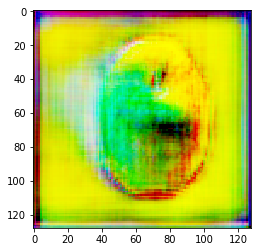

In [13]:
imgA_random=np.random.choice(glob.glob('.\\data\\apple2orange\\testA\\*.jpg'),1)
imA=imageio.imread(imgA_random[0])
imA=scipy.misc.imresize(imA, (128,128,3))
imA=imA/127.5-1

imgB_random=np.random.choice(glob.glob('.\\data\\apple2orange\\testB\\*.jpg'),1)
imB=imageio.imread(imgB_random[0])
imB=scipy.misc.imresize(imB, (128,128,3))
imB=imB/127.5-1

plt.imshow(p[1].predict([imA.reshape(1,128,128,3)])[0])

In [10]:
class CycleGan():
    def __init__(self,path):
        
        self.path=path
        
        self.img_cols =256
        self.img_rows =256
        self.channels =3
        self.img_shape =(self.img_rows, self.img_cols, self.channels)
        
        patch = int(self.img_rows / 2**4)
        self.disc_patch= (patch, patch, 1)
        
        self.gf = 32
        self.df = 64
        
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.9 * self.lambda_cycle    # Identity loss
        
        self.trainA_path=path+"trainA\\"
        self.trainB_path=path+"trainB\\"
        optimizer = Adam(0.0002, 0.5)

        self.d_A= self.build_discriminator()
        self.d_B= self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()
        
        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        
        gen_B = self.g_AB(img_A)
        gen_A = self.g_BA(img_B)
        
        cycle_A = self.g_BA(img_B)
        cycle_B = self.g_AB(img_A)
        
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)
        
        self.d_A.trainable=False
        self.d_B.trainable=False
        
        valid_A=self.d_A(gen_A)
        valid_B=self.d_B(gen_B)
        
        self.combined=Model(inputs=[img_A, img_B],
                           outputs=[valid_A, valid_B, cycle_A, cycle_B,
                                   img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)
        
        
    def conv2d(self, input_layer, output_size, kernel_size=4, strides=2, normalization=True):
        d=Conv2D(output_size, kernel_size=kernel_size, strides=strides, padding='same')(input_layer)
        d=LeakyReLU(alpha=0.2)(d)
        if normalization:
            d=InstanceNormalization()(d)
        return d

    def deconv2d(self, input_layer, skip_input, output_size, kernel_size=4, strides=1, dropout_rate=0):
        u = UpSampling2D(size=2)(input_layer)
        u = Conv2D(output_size, kernel_size=kernel_size, strides=strides, padding='same',activation='relu')(u)
        if dropout_rate:
            u=Dropout(dropout_rate)(u)
        u=InstanceNormalization()(u)
        u=Concatenate()([u, skip_input])
        return u

    def build_generator(self):
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # Upsampling
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):
        img = Input(shape=self.img_shape)

        d1 = self.conv2d(img, self.df, normalization=False)
        d2 = self.conv2d(d1, self.df * 2)
        d3 = self.conv2d(d2, self.df * 4)
        d4 = self.conv2d(d3, self.df * 8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        for epoch in range(epochs):
            imgs=load(self.path, batch_size=1)
            for batch_i, (imgs_A,imgs_B) in enumerate(zip(imgs[0],imgs[1])):
                imgs_A=imgs_A.reshape(1,256,256,3)
                imgs_B=imgs_B.reshape(1,256,256,3)
                fake_B=self.g_AB.predict(imgs_A)
                fake_A=self.g_BA.predict(imgs_B)

                dA_loss_real=self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake=self.d_A.train_on_batch(fake_A, fake)

                dB_loss_real=self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake=self.d_B.train_on_batch(fake_B, fake)

                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])

        return self.d_A, self.d_B, self.g_AB, self.g_BA

In [11]:
def load(path, batch_size, img_shape=(256,256)):
    path_A=glob.glob(path+"trainA\\*")
    path_B=glob.glob(path+"trainB\\*")
    
    img_A=[]
    img_B=[]
    for img_path in path_A:
        img=imageio.imread(img_path,'JPG').astype(np.float)
        img=scipy.misc.imresize(img, img_shape)
        img=np.array(img)/127.5-1
        img_A.append(img)
        
    for img_path in path_B:
        img=imageio.imread(img_path,'JPG').astype(np.float)
        img=scipy.misc.imresize(img, img_shape)
        img=np.array(img)/127.5-1
        img_B.append(img)
        
    return img_A, img_B

In [22]:
cycle_gan=CycleGan("C:\\Users\\David\\Desktop\\Intro_to_Deep_Learning\\data\\monalisa\\")
p=cycle_gan.train(epochs=20, batch_size=1, sample_interval=10)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app


In [13]:
imgs=load("C:\\Users\\David\\Desktop\\Intro_to_Deep_Learning\\data\\monalisa\\", batch_size=1)
imgA,imgB=imgs

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':
C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


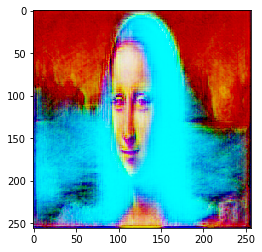

In [21]:
o=p[2].predict(np.array(imgA).reshape(1,256,256,3))
plt.imshow(o[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


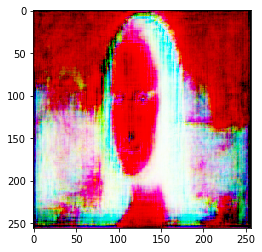

In [19]:
o=p[2].predict(np.array(imgA).reshape(1,256,256,3))
plt.imshow(o[0])